**NLG**

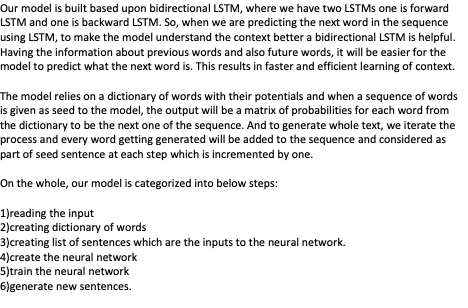

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import nltk as nk
from astropy.table import QTable, Table, Column

In [2]:
s1 = open('internet_archive_scifi_v3.txt', 'rt').read(200000)

**Data pre-processing of Corpus**





In [3]:
s1 = s1.replace('\n', ' ')
s1 = s1.split('.')
tokenizer = nk.RegexpTokenizer(r"\w+")
tokenizedwords=[]
# tokenizedwords+=[tokenizer.tokenize(str.lower()) for str in s1]
no_of_sentences=0
sum_len=0
for str in s1:
  no_of_sentences=no_of_sentences+1
  sum_len+=len(str)
  tokenizedwords+=tokenizer.tokenize(str.lower())
print(type(tokenizedwords))

<class 'list'>


In [4]:
from nltk import word_tokenize, FreqDist
import nltk
nltk.download('punkt')
words = []
for sent in s1:
    for w in word_tokenize(sent):
        words.append(w)
len(words)
fd = FreqDist()
for w in words:
  fd[w] += 1
ranks = []
freqs = []
count = 0;
for temp in fd.most_common():
  count +=1
  ranks.append(count)
  freqs.append(temp[1])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


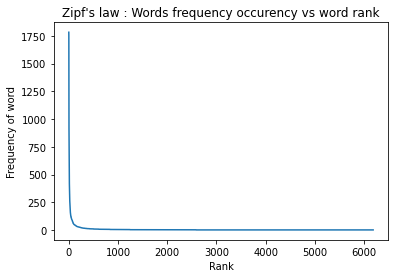

Text(0, 0.5, 'Log frequency of word')

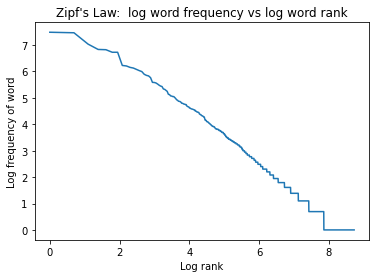

In [6]:
import matplotlib.pyplot as plt
plt.plot(ranks, freqs)
plt.title("Zipf's law : Words frequency occurency vs word rank")
plt.xlabel("Rank")
plt.ylabel("Frequency of word")
plt.show()
# plt.clf()
plt.plot(np.log(ranks), np.log(freqs))
plt.title("Zipf's Law:  log word frequency vs log word rank")
plt.xlabel("Log rank")
plt.ylabel("Log frequency of word")

In [ ]:
print("Total no of tokens=",len(tokenizedwords))
print("Total no of unique tokens=",len(set(tokenizedwords)))
print("Total no of sentences=",no_of_sentences)
print("Average length of sentences=",sum_len/no_of_sentences)
t = Table(rows=[{'Total no of tokens': len(tokenizedwords), 'Total no of unique tokens': len(set(tokenizedwords)), 'Total no of sentences':no_of_sentences,'Average length of sentences':sum_len/no_of_sentences}])
print(t)

Total no of tokens= 37126
Total no of unique tokens= 5627
Total no of sentences= 2822
Average length of sentences= 69.87207654145996
Average length of sentences Total no of sentences ... Total no of unique tokens
--------------------------- --------------------- ... -------------------------
          69.87207654145996                  2822 ...                      5627


To design the network architecture and also to train the model we used Keras and other libraries which are imported in the below code.
Directory to save the trained neural network models is specified.

In [ ]:
from __future__ import print_function
#import Keras library
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM, Input, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.metrics import categorical_accuracy
import numpy as np
import random
import sys
import os
import time
import codecs
import collections
from six.moves import cPickle



save_dir = '/content' 

vocab_file = os.path.join(save_dir, "words_vocab.pkl")
sequences_step = 1 

Creating a dictionary of words without duplicates and assigning index to them.

In [ ]:
word_counts = collections.Counter(tokenizedwords)


vocabulary_inv = [x[0] for x in word_counts.most_common()]
vocabulary_inv = list(sorted(vocabulary_inv))


vocab = {x: i for i, x in enumerate(vocabulary_inv)}
words = [x[0] for x in word_counts.most_common()]


vocab_size = len(words)
print("vocab size: ", vocab_size)


with open(os.path.join(vocab_file), 'wb') as f:
    cPickle.dump((words, vocab, vocabulary_inv), f)

vocab size:  5627


Next we create two lists, one will have all the seeds and the other will have outputs of all the seeds. And we considered our seed length to be 6. We iterate the process and increase the step by 1 each time and obtain all these items of our lists.

In [ ]:
seq_length=6
#creating sequences
sequences = []
next_words = []
for i in range(0, len(tokenizedwords) - seq_length, sequences_step):
    sequences.append(tokenizedwords[i: i + seq_length])
    next_words.append(tokenizedwords[i + seq_length])

print('nb sequences:', len(sequences))

nb sequences: 37120


To ingest by LSTM, we need to deal with boolean matrix.
We considered matrix X and y to be the data inputs of our model.
Matrix X has following dimensions:
no. of sequences,
no. of words in sequences,
no. of words in vocabulary.
Matrix y has following dimensions:
no. of sequences,
no. of words in vocabulary.
For each word which is output of seed, we retrieve its index in the vocabulary, and we set to 1 its position in the matrix. X and y are our training data.

In [ ]:
X = np.zeros((len(sequences), seq_length, vocab_size), dtype=np.bool)
y = np.zeros((len(sequences), vocab_size), dtype=np.bool)
for i, sentence in enumerate(sequences):
    for t, word in enumerate(sentence):
        X[i, t, vocab[word]] = 1
    y[i, vocab[next_words[i]]] = 1

**Building the bidirectional LSTM Model**

In [ ]:
def bidirectional_lstm_model(seq_length, vocab_size):
    print('Build LSTM model.')
    model = Sequential()
    model.add(Bidirectional(LSTM(rnn_size, activation="relu"),input_shape=(seq_length, vocab_size)))
    model.add(Dropout(0.6))
    model.add(Dense(vocab_size))
    model.add(Activation('softmax'))
    
    optimizer = Adam(lr=learning_rate)
    callbacks=[EarlyStopping(patience=2, monitor='val_loss')]
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[categorical_accuracy])
    print("model built!")
    return model

In [ ]:
rnn_size = 256 
seq_length = 6 
learning_rate = 0.001 

md = bidirectional_lstm_model(seq_length, vocab_size)
md.summary()

Build LSTM model.
model built!
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 512)               12050432  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 5627)              2886651   
_________________________________________________________________
activation (Activation)      (None, 5627)              0         
Total params: 14,937,083
Trainable params: 14,937,083
Non-trainable params: 0
_________________________________________________________________


**Training the model**

In [ ]:
from keras.callbacks import ModelCheckpoint
batch_size = 32 
num_epochs = 11

callbacks=[EarlyStopping(patience=4, monitor='val_loss'),
           ModelCheckpoint(filepath=save_dir + "/" + 'my_model_gen_sentences.{epoch:02d}-{val_loss:.2f}.hdf5',\
                           monitor='val_loss', verbose=0, mode='auto', period=2)]
#fitting the model
history = md.fit(X, y,
                 batch_size=batch_size,
                 shuffle=True,
                 epochs=num_epochs,
                 callbacks=callbacks,
                 validation_split=0.1)

#save the model
md.save(save_dir + "/" + 'my_model_generate_sentences.h5')

Epoch 1/11
1044/1044 [==============================] - 390s 373ms/step - loss: 6.7769 - categorical_accuracy: 0.0520 - val_loss: 6.8014 - val_categorical_accuracy: 0.0531
Epoch 2/11
1044/1044 [==============================] - 390s 374ms/step - loss: 6.4427 - categorical_accuracy: 0.0569 - val_loss: 6.8612 - val_categorical_accuracy: 0.0617
Epoch 3/11
1044/1044 [==============================] - 380s 364ms/step - loss: 6.2608 - categorical_accuracy: 0.0636 - val_loss: 6.9585 - val_categorical_accuracy: 0.0620
Epoch 4/11
1044/1044 [==============================] - 383s 366ms/step - loss: 6.0629 - categorical_accuracy: 0.0720 - val_loss: 7.0740 - val_categorical_accuracy: 0.0665
Epoch 5/11
1044/1044 [==============================] - 383s 367ms/step - loss: 5.8286 - categorical_accuracy: 0.0902 - val_loss: 7.1926 - val_categorical_accuracy: 0.0738


In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['categorical_accuracy'])
plt.title('model acccuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('Loss function')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

**Generate Sentences**

In [ ]:
#loading the vocabulary and model previously trained.
print("loading vocabulary...")
vocab_file = os.path.join(save_dir, "words_vocab.pkl")

with open(os.path.join(save_dir, 'words_vocab.pkl'), 'rb') as f:
        words, vocab, vocabulary_inv = cPickle.load(f)

vocab_size = len(words)

from keras.models import load_model

print("loading model...")
model = load_model(save_dir + "/" + 'my_model_generate_sentences.h5')

loading vocabulary...
loading model...


If the temperature value is close to 0, small probabilities will be avoided.  

In [ ]:
def sample(preds, temperature=0.33):
    
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

And for every 6 words given as seed, 30 words will be generated

In [ ]:
def evaluate(seed_sentences) :
 words_number = 30

 generated = ''
 sentence = []
 for i in range (seq_length):
    sentence.append("a")
 seed = seed_sentences.split()
 for i in range(len(seed)):
    sentence[seq_length-i-1]=seed[len(seed)-i-1]
 generated += ' '.join(sentence)
 for i in range(words_number):
    x = np.zeros((1, seq_length, vocab_size))
    for t, word in enumerate(sentence):
        x[0, t, vocab[word]] = 1.
    
    preds = model.predict(x, verbose=0)[0]
    next_index = sample(preds, 0.33)
    next_word = vocabulary_inv[next_index]
    generated += " " + next_word
    sentence = sentence[1:] + [next_word]
 print(generated)

In [ ]:
#First Sample
seed_sentences = "their way of thinking their appreciation"
evaluate(seed_sentences)

their way of thinking their appreciation of the him or began to and the was a other head to a between the they the girl a man a way his other the way of the room


**METRICS USED**

For our Model we used two metrics BLEU and ROUGE. Since in our model, we deal with seeding an input and expect the output to be generated in the form of sentence, we would like to see how far the generated sentence is matching with the reference sentence which is actually present in the original trained data.

**BLEU**

In [8]:
from nltk.translate.bleu_score import sentence_bleu
txt = 'of the him or began to and the was a other head to a between the they the girl a man a way his other the way of the room'
txtnew = txt.split()
reftxt = 'of tke market their interpretation of what you will like best in stories and artwork we have tried to make if different from any other science fiction magazine on the'
reftxtnew = reftxt.split()
reference = [reftxtnew]
candidate = txtnew
score_summary = []
score = sentence_bleu(reference, candidate)
score_summary.append(score)
print(score)

0.668740304976422


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


**ROUGE**

In [ ]:
pip install rouge


In [ ]:
pip install rouge_score

In [ ]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
scores = scorer.score('of tke market their interpretation of what you will like best in stories and artwork we have tried to make if different from any other science fiction magazine on the',
                      'of the him or began to and the was a other head to a between the they the girl a man a way his other the way of the room')
print(scores)

{'rouge1': Score(precision=0.2, recall=0.2, fmeasure=0.20000000000000004), 'rougeL': Score(precision=0.16666666666666666, recall=0.16666666666666666, fmeasure=0.16666666666666666)}


In [ ]:
from rouge import Rouge 

hypothesis = "of the him or began to and the was a other head to a between the they the girl a man a way his other the way of the room"

reference = "of tke market their interpretation of what you will like best in stories and artwork we have tried to make if different from any other science fiction magazine on the"

rouge = Rouge()
scores = rouge.get_scores(hypothesis, reference)
print(scores)

[{'rouge-1': {'f': 0.19999999500000015, 'p': 0.2, 'r': 0.2}, 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-l': {'f': 0.21276595272068824, 'p': 0.2777777777777778, 'r': 0.1724137931034483}}]


**Second Sample**

**BLEU**

In [ ]:
#Second sample
seed_sentences = "your busting right in on the" 
evaluate(seed_sentences)

your busting right in on the was of the lieutenant of lead the girl the was in a eyes of the the door his man and was his thing and and the own so about the


In [9]:
# Second sample
from nltk.translate.bleu_score import sentence_bleu
txt = 'was of the lieutenant of lead the girl the was in a eyes of the the door his man and was his thing and and the own so about the'
txtnew = txt.split()
reftxt = 'professor like that doesnt sound right why not wait in the office for your wife what for cordell squinted at him in surprise he and i get got along fine'
reftxtnew = reftxt.split()
reference = [reftxtnew]
candidate = txtnew
score = sentence_bleu(reference, candidate)
score_summary.append(score)
print(score)

0.5623413251903491


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


**ROUGE**

In [ ]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
scores = scorer.score('professor like that doesnt sound right why not wait in the office for your wife what for cordell squinted at him in surprise he and i get got along fine','was of the lieutenant of lead the girl the was in a eyes of the the door his man and was his thing and and the own so about the')
print(scores)

{'rouge1': Score(precision=0.1, recall=0.1, fmeasure=0.10000000000000002), 'rougeL': Score(precision=0.1, recall=0.1, fmeasure=0.10000000000000002)}


In [ ]:
from rouge import Rouge 

hypothesis = "was of the lieutenant of lead the girl the was in a eyes of the the door his man and was his thing and and the own so about the"

reference = "professor like that doesnt sound right why not wait in the office for your wife what for cordell squinted at him in surprise he and i get got along fine"

rouge = Rouge()
scores = rouge.get_scores(hypothesis, reference)
print(scores)

[{'rouge-1': {'f': 0.09999999500000027, 'p': 0.1, 'r': 0.1}, 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-l': {'f': 0.13333332863209893, 'p': 0.17647058823529413, 'r': 0.10714285714285714}}]


**Third Sample**

**BLEU**

In [ ]:
#Third sample
seed_sentences = "when juanita first went to work"
evaluate(seed_sentences)


when juanita first went to work the s man it was the eyes of the man way and and and was an voice the statement of the light the d gone the man was had the


In [10]:
from nltk.translate.bleu_score import sentence_bleu
txt = 'the s man it was the eyes of the man way and and and was an voice the statement of the light the d gone the man was had the'
txtnew = txt.split()
reftxt = 'for him he said to drop in at the lab any time not to wait in the outer office like a freshman or something go ahead well the young man'
reftxtnew = reftxt.split()
reference = [reftxtnew]
candidate = txtnew
score = sentence_bleu(reference, candidate)
score_summary.append(score)
print(score)

0.6042750794713536


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


**ROUGE**

In [31]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
scores = scorer.score('for him he said to drop in at the lab any time not to wait in the outer office like a freshman or something go ahead well the young man',
                      'the s man it was the eyes of the man way and and and was an voice the statement of the light the d gone the man was had the')
print(scores)

ModuleNotFoundError: ignored

In [32]:
from rouge import Rouge 

hypothesis = "the s man it was the eyes of the man way and and and was an voice the statement of the light the d gone the man was had the"

reference = "for him he said to drop in at the lab any time not to wait in the outer office like a freshman or something go ahead well the young man"

rouge = Rouge()
scores = rouge.get_scores(hypothesis, reference)
print(scores)

ModuleNotFoundError: ignored

**BLEU Plot for all the experiments performed**

The bleu scores for test transcripts are:  [0.668740304976422, 0.5623413251903491, 0.6042750794713536]


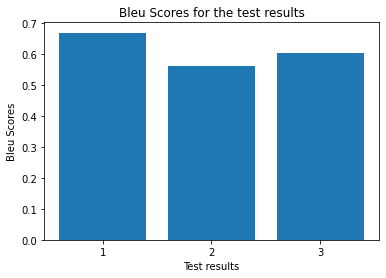

<class 'list'>


In [24]:
bleuScores = score_summary
print("The bleu scores for test transcripts are: ", bleuScores)

tRange = list(range(1,4))
plt.xticks(range(len(bleuScores)), tRange)
plt.xlabel('Test results')
plt.ylabel('Bleu Scores')
plt.title('Bleu Scores for the test results')
plt.bar(range(len(bleuScores)), bleuScores) 
plt.show()
print(type(score_summary))

In [30]:
bleuScores = score_summary
sum=0
for i in bleuScores:
  sum+=i

avg_score = (sum/3)
print(avg_score)



0.6117855698793749
